In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [115]:
df = pd.read_csv('..\\measured_values.csv',skiprows=1, parse_dates=True, index_col=0)
df1 = pd.read_csv('..\\measured_values.csv',skiprows=1, parse_dates=True, index_col=0)
epm = pd.read_excel('..\\energyplus.xlsx', parse_dates=True, index_col=0, sheet_name='energyplus')
epy = pd.read_excel('..\\energyplus.xlsx', parse_dates=True, index_col=0, sheet_name='epyear')

#Calculating Heating Energy Consumption of a House
Uw = 1.5
Upw = 0
Ur = 0.14
Ud = 3
Uf = 0.63
Ug = 2.6
ACH = 0.588
Ag = 31.82
Ad = 6.18
AlivingR = 3.99*3.9
fwlength, swlength, w_height = 9.08, 7, 5.2
Aw = (fwlength+swlength*2)*w_height - Ag-Ad
Ar = swlength*fwlength
Af =  Ar*2
Apw = fwlength*w_height
V = fwlength*swlength*w_height
Da = 1.2
Cp = 1.01

Avtemp = 21*AlivingR/Af + 18.5*(1-AlivingR/Af)
#CALCULATING HEAT TRANSFER COEFFICIENT
HTC = ((Uw*Aw+Upw*Apw+Ur*Ar+Ud*Ad+Uf*Af+Ug*Ag) + (Da*Cp*V*0.589*0.33))/1000
#LOAD MEASURED DATA

#SET POINT TEMPERATURE
df['cTdesign'] = Avtemp - df.Tout
#ACTUAL MEASURED TEMPERATURE
df['cTadj'] = df['AllTin'] - df.Tout
#CALCULATIONS OF HEAT ENERGY BASED ON SCHEDULED TEMPERATURE
df['Measured'] = HTC * df['cTdesign']/0.888
df['MeasuredSync'] = HTC * df['cTdesign']/0.888 * epm['Heating (Gas)'].values/epm['Heating (Gas)'].values
#CALCULATIONS OF HEAT ENERGY BASED ON ACTUAL MEASURED TEMPERATURES
df['MeasuredAdj'] = HTC * df.cTadj/0.888
df['MeasuredSyncAdj'] = HTC * df.cTadj/0.888 * df.GasUsed/df.GasUsed
#MEASURED GAS USE IN KWH - ACCOUNTING FOR BOILER EFFICIENCY
df['Metered'] = df['GasUsed']*0.888
glazing = 0.68
df.fillna(0, inplace=True)


EPq = epy['Zone Heating'].groupby(epy.index.month).sum()
EPTin = epy['Air Temperature'].groupby(epy.index.month).mean()
EPsolarg = epy['Solar Gains Exterior Windows'].groupby(epy.index.month).sum()


data = {'SteadyStateSAP':[2925.02,2417.95,2216.33,1531.00,955.67,379.11,81.58,155.08,561.65,1406.35,2027.00,2954.40],
        'SteadyStateSAPTin': [15.58322094,15.8754172,16.42085825,17.18250471,17.93230824,18.60705871,18.94699117,18.87022053,18.37619157,17.38397033,16.65148631,15.5535212], 
        'SteadyStateSAPSG':[351.374,569.323,785.156,1009.196,1130.902,1188.024,1124.514,1020.249,894.077,648.940,423.085,305.523],
       'EnergyPlus': EPq.values,
       'EnergyPlusTin':EPTin.values,
       'EnergyPlusSG':EPsolarg.values} 
Month ='Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec'.split()
dfy = pd.DataFrame(data, Month)

monthdata = {'EnergyPlus': epm['Zone Heating'].values,
        'EnergyPlusTin': epm['Air Temperature'].values,
         'SteadyStateSAP': df['MeasuredSync']*2027.00/df.MeasuredSync.sum(),
        'Metered': df.Metered.values,
        'ActualTin': df.AllTin.values,
        'Hobo_Tout': df.Tout.values,
        'WS_Tout': epm['Outside Dry-Bulb Temperature'].values}
dfm = pd.DataFrame(monthdata, df.index)

cTseries = df['cTdesign']*epm['Heating (Gas)'].values/epm['Heating (Gas)'].values
cTseries.fillna(0, inplace=True)

(9752.691673, 21965.522190000032)

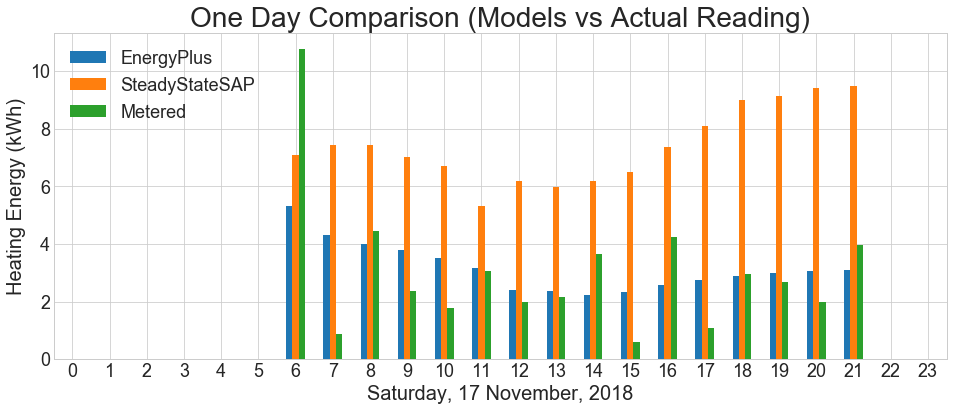

In [67]:
dfm[['EnergyPlus','SteadyStateSAP','Metered']]['2018-11-17'].groupby(dfm['2018-11-17'].index.hour).sum().plot.bar(figsize=(16,6), rot=0, fontsize=18)
plt.title('One Day Comparison (Models vs Actual Reading)', size=28)
plt.ylabel('Heating Energy (kWh)', size=20)
plt.xlabel('Saturday, 17 November, 2018', size=20)
plt.legend(loc=2,prop={'size': 18})

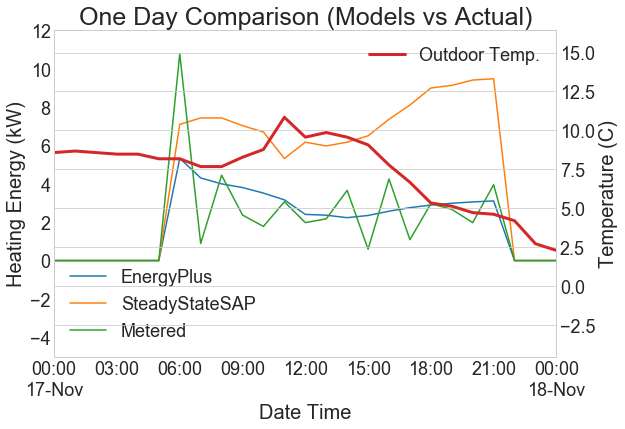

In [70]:
dfm[['EnergyPlus','SteadyStateSAP','Metered']].plot(xlim=(['2018-11-17','2018-11-18']), figsize=(9,6), rot=0, fontsize=16)
plt.title('One Day Comparison (Models vs Actual)', size=25)
plt.ylabel('Heating Energy (kW)', size=20)
plt.xlabel('Saturday, 17 November, 2018', size=20)
df['Tout'].plot(secondary_y=True, fontsize=18, label='Outdoor Temp.', lw=3, ylim=(-5,12))
plt.ylabel('Temperature (C)', size=20)
plt.legend(loc=1,prop={'size': 18})

Text(0.5,0,'Saturday, 17 November, 2018')

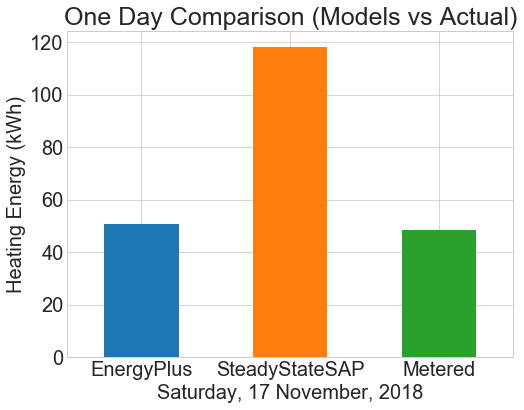

In [71]:
dfm[['EnergyPlus','SteadyStateSAP','Metered']]['2018-11-17'].sum().plot.bar(figsize=(8,6), rot=0, fontsize=20)
plt.title('One Day Comparison (Models vs Actual)', size=25)
plt.ylabel('Heating Energy (kWh)', size=20)
plt.xlabel('Saturday, 17 November, 2018', size=20)
#plt.legend(loc=1,prop={'size': 18})

In [114]:
dfm[['EnergyPlus','SteadyStateSAP','Metered']]['2018-11-17'].sum()

EnergyPlus         50.855510
SteadyStateSAP    118.327882
Metered            48.650175
dtype: float64

In [99]:
(50.855510-48.650175)/48.650175


0.04533046386780737

In [98]:
dfm[['EnergyPlus','SteadyStateSAP','Metered']].groupby(dfm.index.day).sum().idxmax()

EnergyPlus        24
SteadyStateSAP    25
Metered           24
dtype: int64

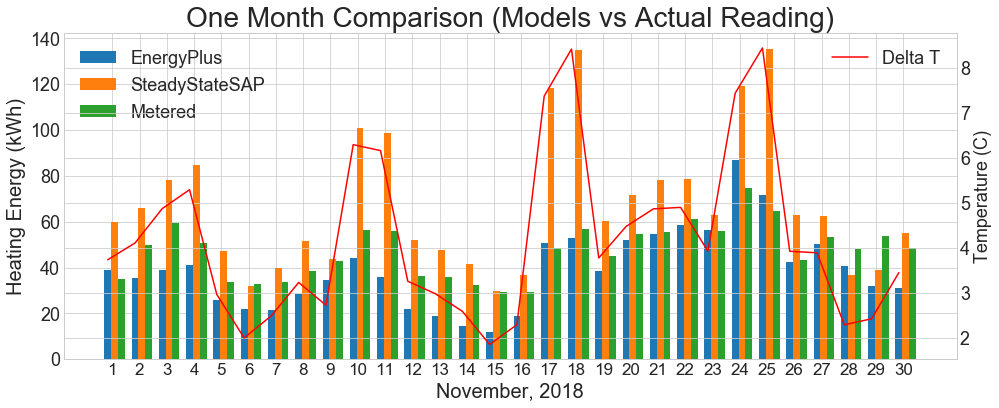

In [73]:
font = {'size' : 18}
import matplotlib
matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(16,6))
index = np.arange(1,31)
width = 0.25

ep = dfm['EnergyPlus'].groupby(dfm.index.day).sum()
sap = dfm['SteadyStateSAP'].groupby(dfm.index.day).sum()
metered = dfm['Metered'].groupby(dfm.index.day).sum()

ax.set_title('One Month Comparison (Models vs Actual Reading)', size=28)
ax.set_xlabel('November, 2018', size=20)
ax.set_ylabel('Heating Energy (kWh)', size=20)
ax.bar(index, ep, width,label='EnergyPlus')
ax.bar(index+width, sap, width,label='SteadyStateSAP')
ax.bar(index+width*2, metered, width,label='Metered')

ax.set_xticks(index + width*2 / 3)
ax.set_xticklabels(index, size=17)
ax.legend(loc=2,prop={'size': 18})

ax1 = ax.twinx()
ax1.set_ylabel('Temperature (C)')
cT = cTseries.groupby(dfm.index.day).mean()
ax1.plot(index, cT, label='Delta T', color='r')
ax1.legend(loc=1,prop={'size': 18})

In [113]:
dfm[['EnergyPlus','SteadyStateSAP','Metered']].sum()

EnergyPlus        1171.730495
SteadyStateSAP    2027.000000
Metered           1417.776861
dtype: float64

In [104]:
(1171.730495-1417.776861)/1417.776861, (2027.000000- 1417.776861)/1417.776861

(-0.17354378729700543, 0.4297031188464289)

In [102]:
dfm[['EnergyPlus','SteadyStateSAP','Metered']]['2018-11-16':'2018-11-30'].sum()

EnergyPlus         738.104892
SteadyStateSAP    1152.765643
Metered            794.520650
dtype: float64

In [74]:
dfm[['EnergyPlus','SteadyStateSAP','Metered']].groupby(dfm.index.day).sum().idxmax()

EnergyPlus        24
SteadyStateSAP    25
Metered           24
dtype: int64

In [75]:
dfm[['EnergyPlus','SteadyStateSAP','Metered']].groupby(dfm.index.day).sum().idxmin()

EnergyPlus        15
SteadyStateSAP    15
Metered           16
dtype: int64

In [77]:
dfm[['EnergyPlus','SteadyStateSAP','Metered']].idxmax()

EnergyPlus       2018-11-22 07:00:00
SteadyStateSAP   2018-11-22 07:00:00
Metered          2018-11-22 06:00:00
dtype: datetime64[ns]

In [78]:
dfm[['EnergyPlus','SteadyStateSAP','Metered']].sum()

EnergyPlus        1171.730495
SteadyStateSAP    2027.000000
Metered           1417.776861
dtype: float64

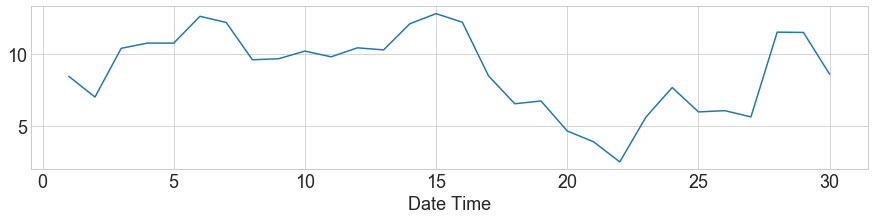

In [519]:
dfm['WS_Tout'].groupby(df.index.day).mean().plot(figsize=(15,3))

In [57]:
dfm['SteadyStateSAP']['2018-11-15'].sum(), dfm['SteadyStateSAP']['2018-11-28'].sum()

(33.326012335076584, 41.239238010101964)

Text(0.5,0,'November, 2018')

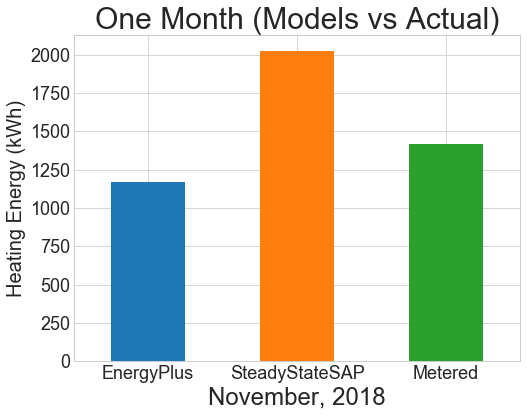

In [77]:
dfm[['EnergyPlus','SteadyStateSAP','Metered']].sum().plot.bar(figsize=(8,6), rot=0, fontsize=18)
plt.title('One Month (Models vs Actual)', size=30)
plt.ylabel('Heating Energy (kWh)', size=20)
plt.xlabel('November, 2018', size=24)
#plt.legend(loc=2,prop={'size': 18})

In [107]:
dfm[['EnergyPlus','SteadyStateSAP','Metered']].sum()

EnergyPlus        1171.730495
SteadyStateSAP    2027.000000
Metered           1417.776861
dtype: float64

In [62]:
(2282.666000-1417.776861)/ 1417.776861,  (1417.776861-1319.516315)/ 1417.776861


(0.6100319188380379, 0.0693060725583389)

In [109]:
dfy[['EnergyPlus','SteadyStateSAP']].sum()

EnergyPlus         9479.706879
SteadyStateSAP    16433.720000
dtype: float64

Text(0,0.5,'Heating Energy (kWh)')

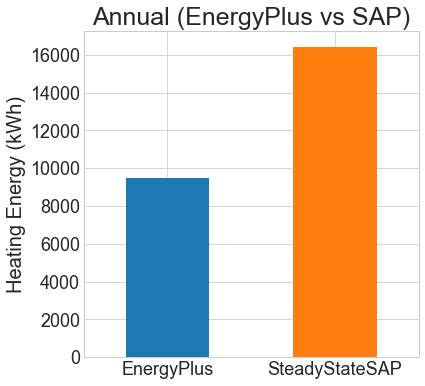

In [108]:
dfy[['EnergyPlus','SteadyStateSAP']].sum().plot.bar(figsize=(6,6), rot=0, fontsize=18)
plt.title('Annual (EnergyPlus vs SAP)', size=25)
plt.ylabel('Heating Energy (kWh)', size=20)
#plt.xlabel('November, 2018', size=20)
#plt.legend(loc=9,prop={'size': 20})

Text(0,0.5,'Heating Energy (kWh)')

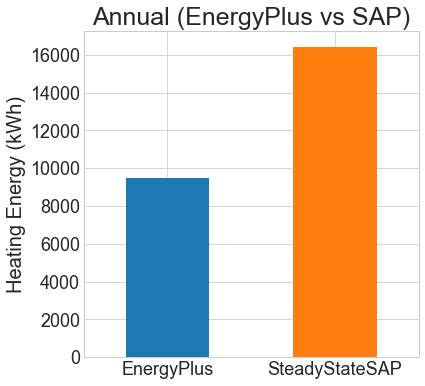

In [105]:
dfy[['EnergyPlus','SteadyStateSAP']].sum().plot.bar(figsize=(6,6), rot=0, fontsize=18)
plt.title('Annual (EnergyPlus vs SAP)', size=25)
plt.ylabel('Heating Energy (kWh)', size=20)
#plt.xlabel('November, 2018', size=20)
#plt.legend(loc=9,prop={'size': 20})

In [112]:
dfy[['EnergyPlus','SteadyStateSAP']].sum()

EnergyPlus         9479.706879
SteadyStateSAP    16433.720000
dtype: float64

In [111]:
 (16433.720000-9479.706879)/9479.706879


0.7335683697567631

In [80]:
dfy[['EnergyPlus','SteadyStateSAP']].sum()

EnergyPlus         9752.691673
SteadyStateSAP    17611.140000
dtype: float64

In [3]:
dfy[['EnergyPlus','SteadyStateSAP']].sum(), (18506.450000-10982.761095)/10982.761095b

(EnergyPlus        10982.761095
 SteadyStateSAP    18506.450000
 dtype: float64, 0.6850453032639695)

In [91]:
dfy.head()

,SteadyStateSAP,SteadyStateSAPTin,SteadyStateSAPSG,EnergyPlus,EnergyPlusTin,EnergyPlusSG
Jan,2925.02,15.583221,351.374,1842.676307,14.650874,347.016426
Feb,2417.95,15.875417,569.323,1585.169457,15.257835,516.004822
Mar,2216.33,16.420858,785.156,1157.656991,16.590121,839.437367
Apr,1531.00,17.182505,1009.196,831.041823,17.125058,1022.350483
May,955.67,17.932308,1130.902,345.988651,18.365546,1154.652408


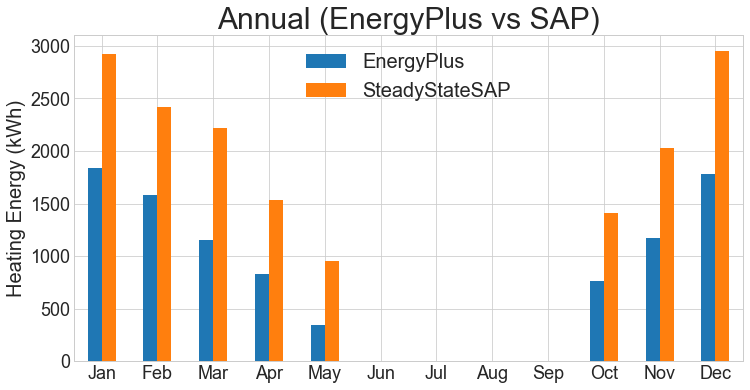

In [95]:
dfy['EnergyPlus'].iloc[5:9,] = 0 #This is to force summer months to zero.
dfy['SteadyStateSAP'].iloc[5:9,] = 0 #This is to force summer months to zero.
dfy[['EnergyPlus','SteadyStateSAP']].plot.bar(figsize=(12,6), rot=0, fontsize=18)
plt.title('Annual (EnergyPlus vs SAP)', size=30)
plt.ylabel('Heating Energy (kWh)', size=20)
#plt.xlabel('November, 2018', size=20)
plt.legend(loc=9,prop={'size': 20})

In [93]:
dfm.head()

,EnergyPlus,EnergyPlusTin,SteadyStateSAP,Metered,ActualTin,Hobo_Tout,WS_Tout
Date Time,,,,,,,
2018-11-01 00:00:00,0.0,13.76640,0.0,0.0,14.316636,7.983,7.083333
2018-11-01 01:00:00,0.0,13.65687,0.0,0.0,14.229545,8.082,8.441667
2018-11-01 02:00:00,0.0,13.45270,0.0,0.0,14.142273,8.182,8.575000
2018-11-01 03:00:00,0.0,13.30474,0.0,0.0,14.072636,8.481,8.933333
2018-11-01 04:00:00,0.0,13.17486,0.0,0.0,13.994000,8.581,9.216666


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Metered & EnergyPlus Correlation')

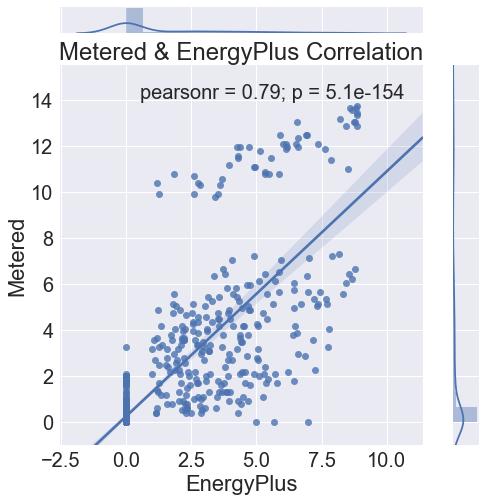

In [89]:
sns.set(font_scale=2)
sns.jointplot(x='EnergyPlus', y='Metered', data=dfm, kind='reg', size=7.5, ratio=7, ylim=(-1,15.5), space=1.2)
plt.title('Metered & EnergyPlus Correlation')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Metered & SAP Correlation')

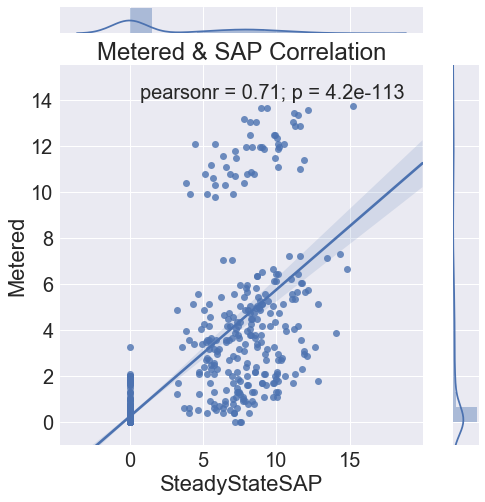

In [567]:
sns.jointplot(x='SteadyStateSAP', y='Metered', data=dfm, kind='reg', size=7.5, ratio=7, ylim=(-1,15.5), space=1.2)
plt.title('Metered & SAP Correlation')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'EnergyPlus & SAP Correlation (November)')

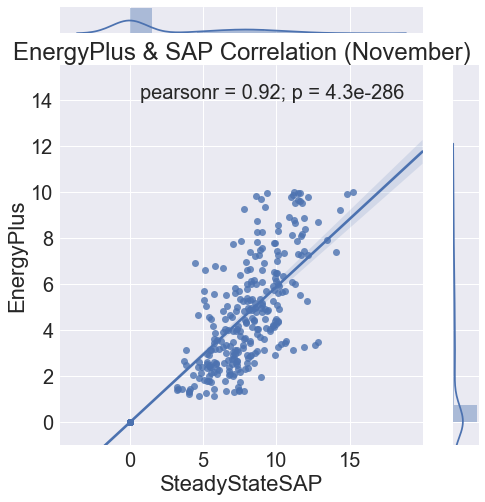

In [568]:
sns.jointplot(x='SteadyStateSAP', y='EnergyPlus', data=dfm, kind='reg', size=7.5, ratio=7, ylim=(-1,15.5), space=1.2)
plt.title('EnergyPlus & SAP Correlation (November)')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'EnergyPlus & SAP (Annual)')

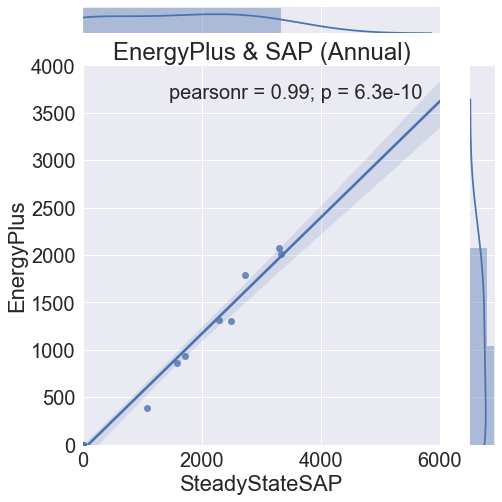

In [61]:
sns.jointplot(x='SteadyStateSAP', y='EnergyPlus', data=dfy, kind='reg', size=7.5, ratio=7, ylim=(-1,4001), xlim=(-1,6001), space=1.2)
plt.title('EnergyPlus & SAP (Annual)')

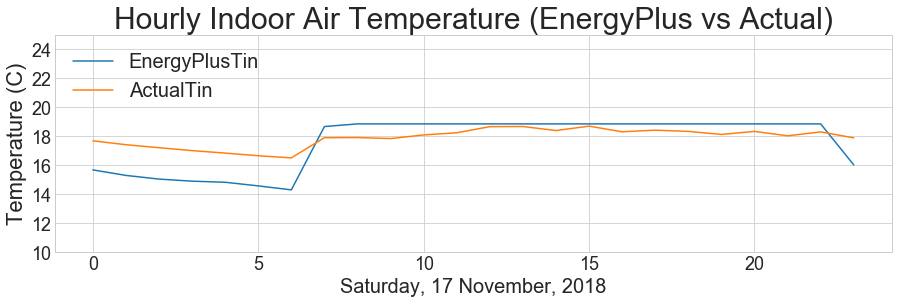

In [8]:
dfm[['EnergyPlusTin','ActualTin']]['2018-11-17'].groupby(dfm['2018-11-17'].index.hour).mean().plot(figsize=(15,4), rot=0, fontsize=18, ylim=(10,25))
plt.title('Hourly Indoor Air Temperature (EnergyPlus vs Actual)', size=30)
plt.ylabel('Temperature (C)', size=22)
plt.xlabel('Saturday, 17 November, 2018', size=20)
plt.legend(loc=2,prop={'size': 20})

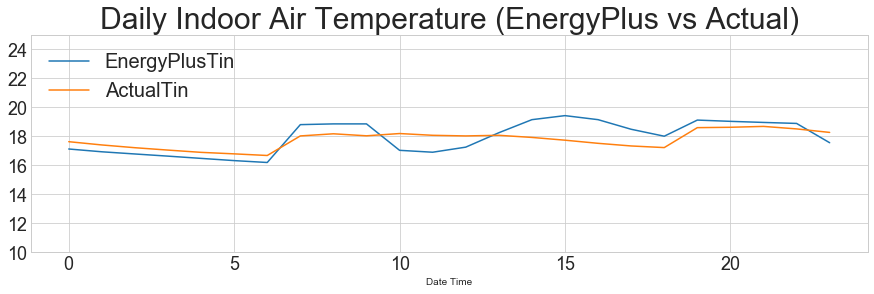

In [9]:
#dfm[['EnergyPlus','SteadyStateSAP','Metered']]['2018-11-17'].groupby(dfm['2018-11-17'].index.hour).sum().plot.bar(figsize=(16,6), rot=0, fontsize=18)
dfm[['EnergyPlusTin','ActualTin']]['2018-11-15'].groupby(dfm['2018-11-15'].index.hour).mean().plot(figsize=(15,4), rot=0, fontsize=18, ylim=(10,25))
plt.title('Daily Indoor Air Temperature (EnergyPlus vs Actual)', size=30)
plt.legend(loc=2,prop={'size': 20})

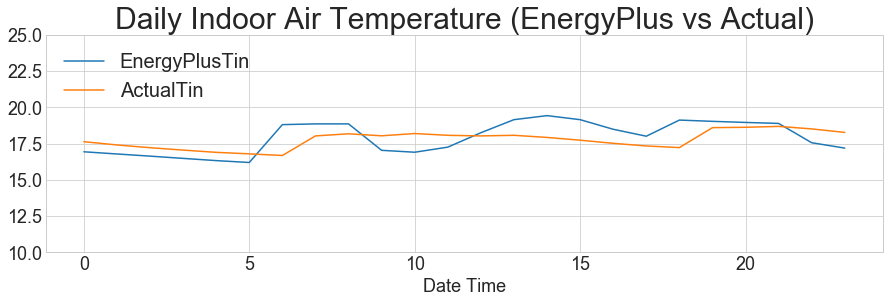

In [81]:
#dfm[['EnergyPlus','SteadyStateSAP','Metered']]['2018-11-17'].groupby(dfm['2018-11-17'].index.hour).sum().plot.bar(figsize=(16,6), rot=0, fontsize=18)
dfm[['EnergyPlusTin','ActualTin']]['2018-11-15'].groupby(dfm['2018-11-15'].index.hour).mean().plot(figsize=(15,4), rot=0, fontsize=18, ylim=(10,25))
plt.title('Daily Indoor Air Temperature (EnergyPlus vs Actual)', size=30)
plt.legend(loc=2,prop={'size': 20})

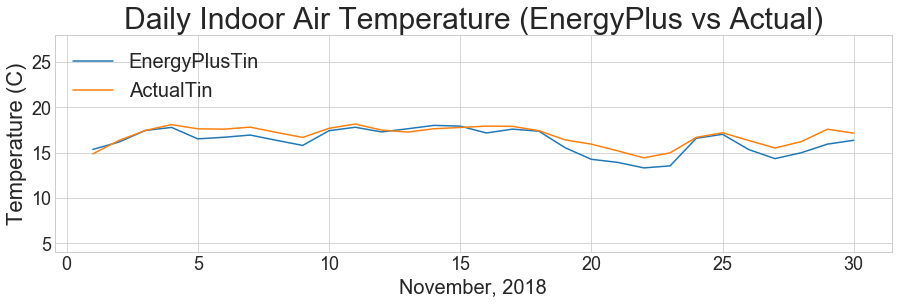

In [35]:
dfm[['EnergyPlusTin','ActualTin']].groupby(dfm.index.day).mean().plot(figsize=(15,4), rot=0, fontsize=18, ylim=(4,28))
plt.title('Daily Indoor Air Temperature (EnergyPlus vs Actual)', size=30)
plt.ylabel('Temperature (C)', size=22)
plt.xlabel('November, 2018', size=20)
plt.legend(loc=2,prop={'size': 20})

In [ ]:
dfm[['EnergyPlusTin','ActualTin']].groupby(dfm.index.day).mean().plot(figsize=(15,4), rot=0, fontsize=18, ylim=(4,28))
plt.title('Daily Indoor Air Temperature (EnergyPlus vs Actual)', size=30)
plt.ylabel('Temperature (C)', size=22)
plt.xlabel('November, 2018', size=20)
plt.legend(loc=2,prop={'size': 20})

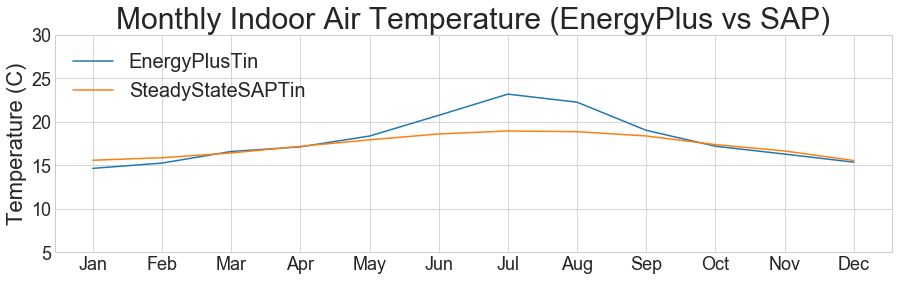

In [98]:
font = {'size' : 18}
import matplotlib
matplotlib.rc('font', **font)

plt.figure(figsize=(15,4))
plt.ylim(5,30)
plt.plot(Month,dfy.EnergyPlusTin)
plt.plot(Month,dfy.SteadyStateSAPTin)
plt.title('Monthly Indoor Air Temperature (EnergyPlus vs SAP)', size=30)
plt.ylabel('Temperature (C)', size=22)
#plt.xlabel('November, 2018', size=20)
plt.legend(loc=2,prop={'size': 20})

Text(0.5,0,'November, 2018')

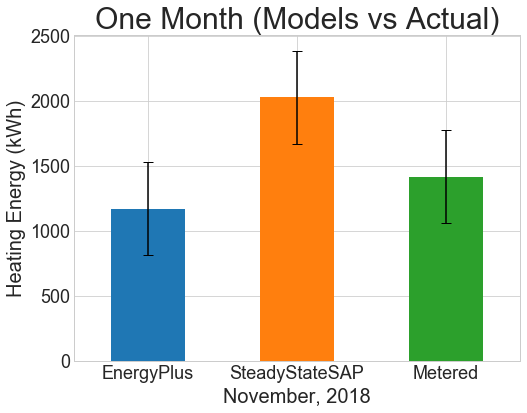

In [10]:
dfm[['EnergyPlus','SteadyStateSAP','Metered']].sum().plot.bar(figsize=(8,6), rot=0, fontsize=18,
                                                            yerr=0.496*24*30, ecolor='black', capsize=5)
plt.title('One Month (Models vs Actual)', size=30)
plt.ylabel('Heating Energy (kWh)', size=20)
plt.xlabel('November, 2018', size=20)
#plt.legend(loc=2,prop={'size': 18})

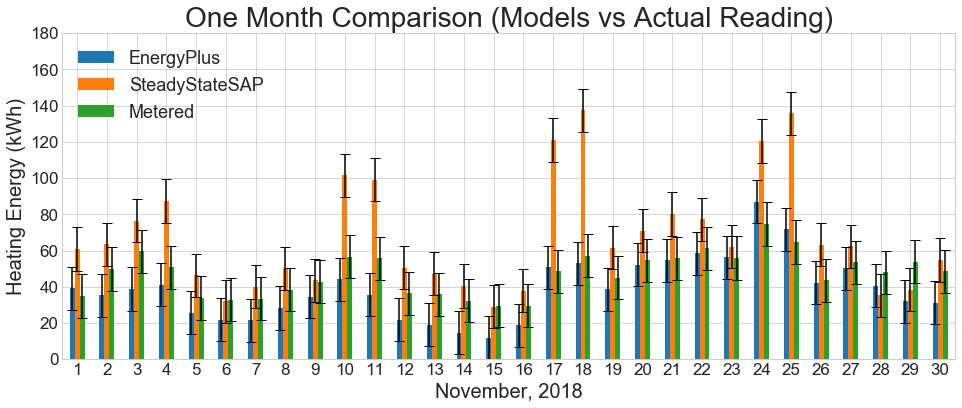

In [11]:
dfm[['EnergyPlus','SteadyStateSAP','Metered']].groupby(dfm.index.day).sum().plot.bar(ylim= (0,180),figsize=(16,6), rot=0,
                fontsize=17, yerr=0.496*24, ecolor='black', capsize=5)
plt.title('One Month Comparison (Models vs Actual Reading)', size=28)
plt.ylabel('Heating Energy (kWh)', size=20)
plt.xlabel('November, 2018', size=20)
plt.legend(loc=2,prop={'size': 18})

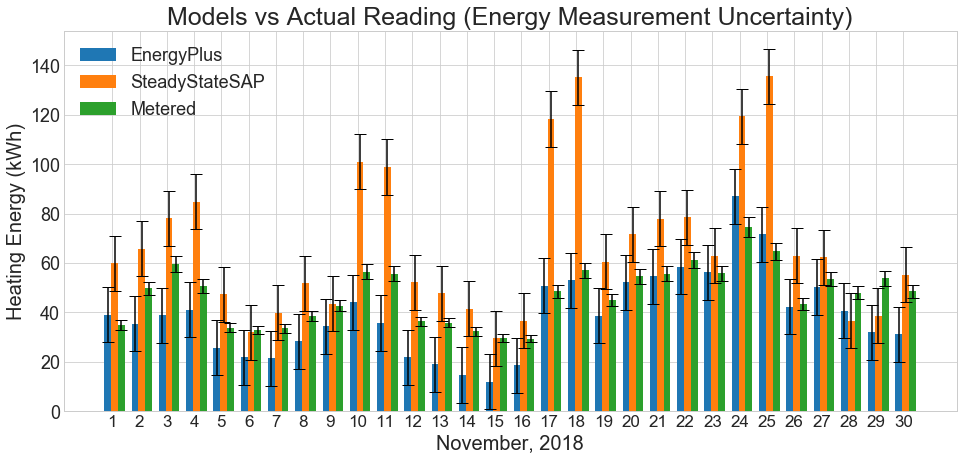

In [96]:
fig, ax = plt.subplots(figsize=(16,7))

ep = dfm['EnergyPlus'].groupby(dfm.index.day).sum()
sap = dfm['SteadyStateSAP'].groupby(dfm.index.day).sum()
metered = df['Metered'].groupby(df.index.day).sum()
index = np.arange(1,31)
width = 0.25
config = {'ecolor': '0.3'}

ax.bar(index, ep, width,label='EnergyPlus', yerr=0.465*24, ecolor='black', capsize=6)
ax.bar(index+width, sap, width, label='SteadyStateSAP', yerr=0.465*24, ecolor='black', capsize=6)
ax.bar(index+width*2, metered, width, label='Metered', yerr=df.Metered.groupby(df.index.day).sum()*0.054, capsize=6)

ax.set_xlabel('November, 2018', size=20)
ax.set_ylabel('Heating Energy (kWh)', size=20)
ax.set_title('Models vs Actual Reading (Energy Measurement Uncertainty)', size=25)
ax.set_xticks(index + width*2 / 3)
ax.set_xticklabels(index, size=17)
ax.legend(loc=2,prop={'size': 18})

In [13]:
dfm[['EnergyPlus','SteadyStateSAP']].sum(), dfm[['EnergyPlus','SteadyStateSAP']]['2018-11-17'].sum()

(EnergyPlus        1171.730495
 SteadyStateSAP    2027.000000
 dtype: float64, EnergyPlus         50.855510
 SteadyStateSAP    121.052204
 dtype: float64)

In [21]:
0.465*24, 0.465*24*30, 0.465*24*365

(11.16, 334.8, 4073.4)

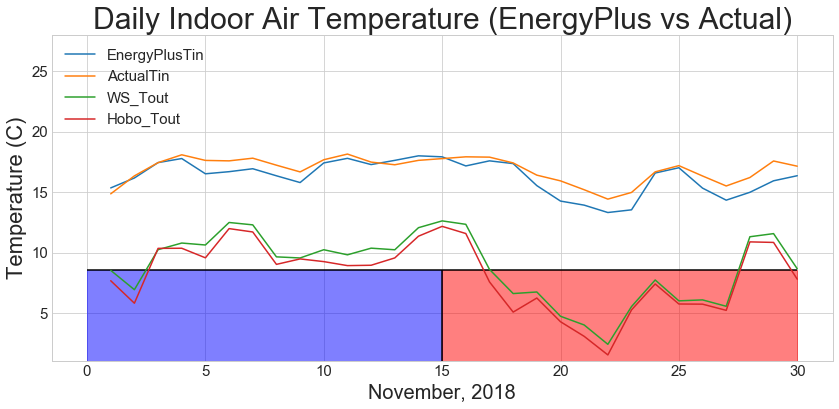

In [14]:
dfm[['EnergyPlusTin','ActualTin', 'WS_Tout', 'Hobo_Tout']].groupby(dfm.index.day).mean().plot(figsize=(14,6), rot=0, fontsize=15, ylim=(1,28))
plt.title('Daily Indoor Air Temperature (EnergyPlus vs Actual)', size=30)
plt.ylabel('Temperature (C)', size=22)
plt.xlabel('November, 2018', size=20)
plt.legend(loc=2,prop={'size': 15})
plt.hlines(y=8.55, xmin=0, xmax=30, hold=None)
plt.vlines(x=15, ymin=0, ymax=8.55, hold=None)
plt.fill_between(np.arange(0,16), 0, 8.55, alpha=0.5, color='b')
plt.fill_between(np.arange(15,31), 0, 8.55, alpha=0.5, color='red')

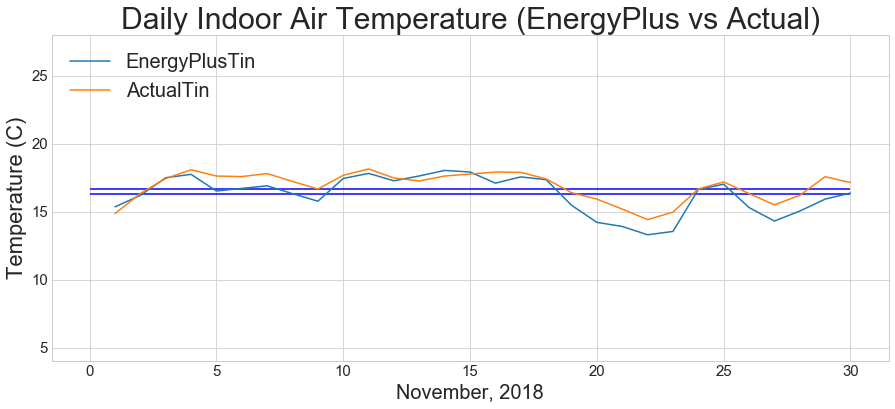

In [20]:
dfm[['EnergyPlusTin','ActualTin']].groupby(dfm.index.day).mean().plot(figsize=(15,6), rot=0, fontsize=15, ylim=(4,28))
plt.hlines(y=16.651, xmin=0, xmax=30, color='b')
plt.hlines(y=16.283, xmin=0, xmax=30, color='b')
plt.title('Daily Indoor Air Temperature (EnergyPlus vs Actual)', size=30)
plt.ylabel('Temperature (C)', size=22)
plt.xlabel('November, 2018', size=20)
plt.legend(loc=2,prop={'size': 20})

In [29]:
df['Tout']['2018-11-01':'2018-11-15':].mean()

9.743400000000008

In [30]:
df['Tout']['2018-11-16':'2018-11-30':].mean()

6.546938888888892

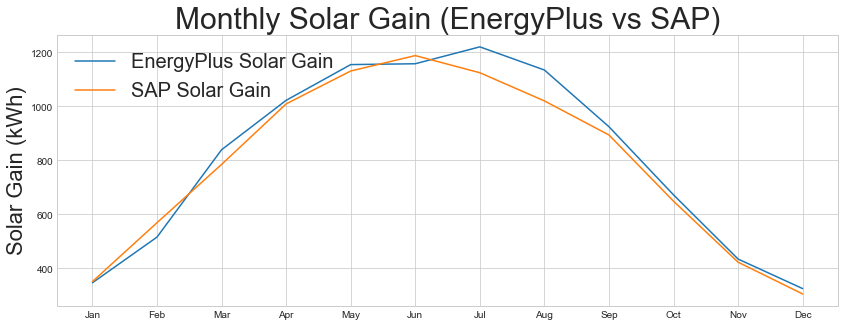

In [15]:
plt.figure(figsize=(14,5))
plt.plot(Month,dfy.EnergyPlusSG, label= 'EnergyPlus Solar Gain')
plt.plot(Month,dfy.SteadyStateSAPSG, label= 'SAP Solar Gain')
plt.title('Monthly Solar Gain (EnergyPlus vs SAP)', size=30)
plt.ylabel('Solar Gain (kWh)', size=22)
#plt.xlabel('November, 2018', size=20)
plt.legend(loc=2,prop={'size':20})

In [96]:
dfm['2018-11-01':'2018-11-15'][['EnergyPlus','SteadyStateSAP','Metered']].sum()

EnergyPlus        488.317122
SteadyStateSAP    955.734692
Metered           623.256211
dtype: float64

In [95]:
dfm['2018-11-16':'2018-11-30'][['EnergyPlus','SteadyStateSAP','Metered']].sum()

EnergyPlus         831.199193
SteadyStateSAP    1326.951255
Metered            794.520650
dtype: float64

In [84]:
dfm['2018-11-01':'2018-11-15']['EnergyPlus'].sum()/dfm['2018-11-01':'2018-11-15']['SteadyStateSAP'].sum()

0.5109337624553889

In [85]:
dfm['2018-11-16':'2018-11-30']['EnergyPlus'].sum()/dfm['2018-11-16':'2018-11-30']['SteadyStateSAP'].sum()

0.6263976840600141

In [107]:
dfm['2018-11-01':'2018-11-15']['SteadyStateSAP'].sum()

955.7346918185631

In [109]:
dfm['2018-11-01':'2018-11-15']['WS_Tout'].mean()

10.447060180555551

In [118]:
dfm['2018-11-01':'2018-11-15']['SteadyStateSAP'].sum()/dfm['2018-11-01':'2018-11-15']['ChangeT'].mean()

139.17145564594836

In [119]:
dfm['2018-11-16':'2018-11-30']['SteadyStateSAP'].sum()/dfm['2018-11-16':'2018-11-30']['ChangeT'].mean()

142.93660355402744

In [120]:
dfm['2018-11-01':'2018-11-15']['EnergyPlus'].sum()/dfm['2018-11-01':'2018-11-15']['ChangeT'].mean()

71.10739545957767

In [121]:
dfm['2018-11-16':'2018-11-30']['EnergyPlus'].sum()/dfm['2018-11-16':'2018-11-30']['ChangeT'].mean()

89.53515743364717

In [115]:
dfm['ChangeT'] = dfm['ActualTin'] - dfm['WS_Tout']

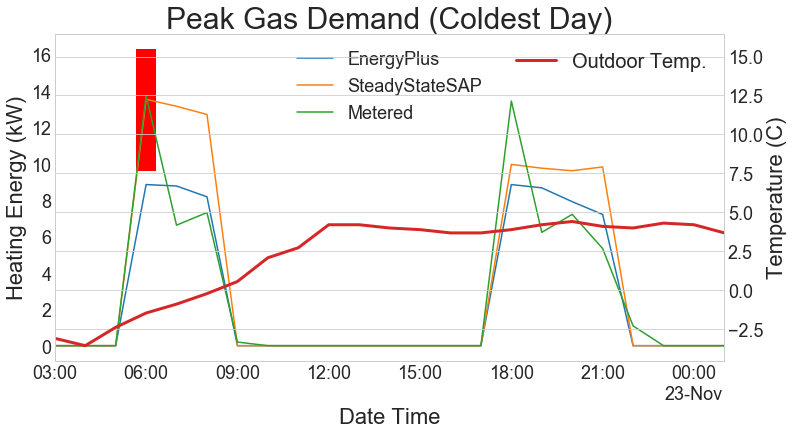

In [82]:
font = {'size' : 18}
import matplotlib
matplotlib.rc('font', **font)

dfm[['EnergyPlus','SteadyStateSAP','Metered']].plot(xlim=['2018-11-22 03:00','2018-11-23 01:00'], 
                                                    figsize=(12,6), rot=0, fontsize=18)
plt.vlines(x='2018-11-22 06:00', ymin=9.6, ymax=16.3, hold=None, lw=20, color='r')
plt.title('Peak Gas Demand (Coldest Day)', size=30)
plt.ylabel('Heating Energy (kW)', size=22)
plt.xlabel('22 November, 2018', size=22)
df['Tout'].plot(secondary_y=True, fontsize=18, label='Outdoor Temp.', lw=3)
plt.ylabel('Temperature (C)', size=22)
plt.legend(loc=1,prop={'size':20})

In [288]:
len(df['Tout']['2018-11-22':'2018-11-23'].values)

48